# Data Exploration

## Motivation
Currently AI is advancing in the field of healthcare to improve detection of malignant tumors, give treatment recommendations, engage patients and support in administrative activities (Davenport and Kalakota 2019). Our goal is to contribute to this field by applying a neural network with transfer learning on a dataset with the aim to detect malignant cells of breast cancer. 

According to Krebsliga Schweiz (2021), there are 6’250 new cases and 1’410 deaths associated with breast cancer in Switzerland every year. Early diagnosis and treatment are a key to increasing the 5-year survival rate of patients.  

From a technical standpoint we want to investigate the performance differences between neural networks with and without transfer learning in the field of tumor detection.

## Data

We use the Kaggle dataset: Breast Histopathology Images, which contains 277’524 images that are classified whether the sample is positive or negative for Invasive Ductal Carcinoma (IDC). Therefore, we face a binary classification problem with this dataset. The sample dataset contains images scanned at 40x zoom that are prepared in 50 x 50-pixel patches.

[Kaggle Dataset](https://www.kaggle.com/paultimothymooney/breast-histopathology-images)

In [1]:
import IPython
import pandas as pd
import numpy as np
import datetime
import pickle

# used to access folder structures
import os

# used to open images
import PIL

# Graphs, visualizations
import matplotlib.pyplot
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import scipy

# import tensorflow as tf
import keras

# For Image Data Augmentation
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# from tensorflow.keras.callbacks import ReduceLROnPlateau
# from tensorflow.keras.layers import Flatten, Dense, BatchNormalization, Activation, Dropout
# from tensorflow.keras import layers
from keras.optimizers import Adam, SGD


from sklearn.model_selection import train_test_split

# Data preparation
* Initialize the path to all the images
* Create a dataframe with 3 collumns, which store the patient Id, the path to the picture and the picture itself
* Crete the new file strucure 

In [2]:
base_path = "IDC_regular_ps50_idx5/"
folder = os.listdir(base_path)
print("No. of Patients total:",len(folder))

total_images = 0
for n in range(len(folder)):
    patient_id = folder[n]
    for c in [0, 1]:
        patient_path = base_path + patient_id
        class_path = patient_path + '/' + str(c) + '/'
        subfiles = os.listdir(class_path)
        total_images += len(subfiles)
        
print("Total Images in dataset: ", total_images )

No. of Patients total: 279
Total Images in dataset:  277524


In total there are 279 patients in our dataset, from images of those patients in total 277'524 patches were created which each consist of a 50x50 pixel patch. While the number of patches to be analysed consists of a good number of samples to train a neural network, the relatively low number of patients indicates that further verification of our results would be needed to confirm generalizablility.  

Next we iterate over the whole folder structure with all the data and fill two dataframes:
* One dataframe (data) holds the patient id, path to the patch as well as the target label. It will be used to prepare the ndarray creation for our X and y.
* The second dataframe (patientData) holds the patient id and the number of positive as well as negative patches per patient. This will be used for some visualisations and exploratory analysis of the data.

In [3]:
# create an empty dataframe with a column for each the patient id,
# the path to the image and the target label for each patch
data = pd.DataFrame(index=np.arange(0, total_images), columns=["patient_id", "path", "target"])

patientData = pd.DataFrame(index=np.arange(0, len(folder)), columns=["patient_id", "nrPos", "nrNeg"])

k = 0
n = 0
# Iterate over all patients (1 folder = 1 patient)
for i in range(len(folder)):
    
    # Fill the patient Data dataframe with the patient and the number of pos and neg patches
    if n > 0:
        patientData.iloc[n-1]["patient_id"] = patient_id
        patientData.iloc[n-1]["nrPos"] = nrPos
        patientData.iloc[n-1]["nrNeg"] = nrNeg
    
    nrPos = 0
    nrNeg = 0
    
    patient_id = folder[n]
    patient_path = base_path + patient_id 
    
    # Iterate over the two subfolders with the negative and positive patches 
    for c in [0,1]:        
        class_path = patient_path + "/" + str(c) + "/"
        subfiles = os.listdir(class_path)
        
        # Iterate over the images in the subfolder and fill the dataframe
        for m in range(len(subfiles)):
            
            # Count the number of positive and negative patches per patient
            if c == 0:
                nrNeg += 1
            else:
                nrPos += 1
            
            image_path = subfiles[m]
            data.iloc[k]["path"] = class_path + image_path
            data.iloc[k]["target"] = c
            data.iloc[k]["patient_id"] = patient_id
            k += 1
    n += 1

# write the last patient
patientData.iloc[n-1]["patient_id"] = patient_id
patientData.iloc[n-1]["nrPos"] = nrPos
patientData.iloc[n-1]["nrNeg"] = nrNeg

In [4]:
data.head()

,patient_id,path,target
0,10253,IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001...,0
1,10253,IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001...,0
2,10253,IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001...,0
3,10253,IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001...,0
4,10253,IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001...,0


In [5]:
CSS = """
div.cell:nth-child(24) .output {
    flex-direction: row;
}
"""
HTML('<style>{}</style>'.format(CSS))

In [6]:
display(data.head())
display(patientData.head())

,patient_id,path,target
0,10253,IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001...,0
1,10253,IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001...,0
2,10253,IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001...,0
3,10253,IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001...,0
4,10253,IDC_regular_ps50_idx5/10253/0/10253_idx5_x1001...,0


,patient_id,nrPos,nrNeg
0,10253,70,479
1,10254,76,772
2,10255,91,181
3,10256,117,351
4,10257,208,427


In [7]:
X_data=[]
y_data=[]
resized = 0

for index, row in data[:].iterrows():
    image = PIL.Image.open(row['path'])
    npImage = np.asarray(image)
    
    # Resize images with format different than our 50x50 patches
    if npImage.shape != (50, 50, 3):
        resized += 1
        image = image.resize((50, 50))
        npImage = np.asarray(image)
    X_data.append(npImage)
    y_data.append(row['target'])
    
    
print('X_data shape: ', np.array(X_data).shape)
print('y_data shape: ', np.array(y_data).shape)

print('In total %d patches had to be resized, since the format differed from 50x50'%resized)

X_data shape:  (277524, 50, 50, 3)
y_data shape:  (277524,)
In total 2302 patches had to be resized, since the format differed from 50x50


In [8]:
sum(patientData['nrPos']), sum(patientData['nrNeg'])

sum(patientData['nrNeg']) / (sum(patientData['nrPos']) + sum(patientData['nrNeg']))

0.7161110390452717

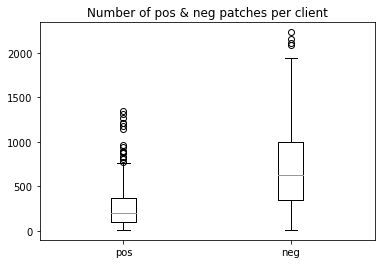

In [9]:
ax = matplotlib.pyplot
ax.boxplot([patientData.nrPos, patientData.nrNeg], labels=['pos', 'neg'])
ax.title('Number of pos & neg patches per client')
ax.xticks=([1, 2], ['pos', 'neg'])

[]

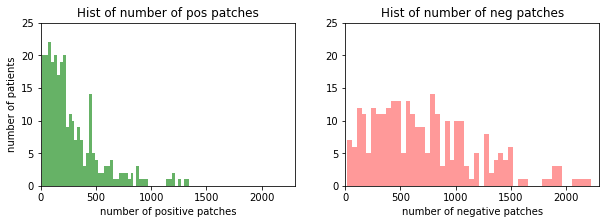

In [10]:
f = matplotlib.pyplot.figure(figsize=(10,3))

ax = f.add_subplot(121, ylim=(0, 25), ylabel='number of patients', xlabel='number of positive patches', xlim=(0, 2300), title='Hist of number of pos patches')
ax2 = f.add_subplot(122, ylim=(0, 25), xlabel='number of negative patches', xlim=(0, 2300), title='Hist of number of neg patches')

ax.hist(patientData.nrPos, bins=50, alpha=.6, color='g')
ax2.hist(patientData.nrNeg, bins=50, alpha=.4, color='r')

matplotlib.pyplot.plot()